In [902]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import os

#temporal data -> temporal models
#research balance between days included
#meet with professor

#### Loading in and Cleaning Data

In [903]:
plant1_gen_path = r'data/Plant_1_Generation_Data.csv'
plant1_weather_path = r'data/Plant_1_Weather_Sensor_Data.csv'

plant2_gen_path = r'data/Plant_2_Generation_Data.csv'
plant2_weather_path = r'data/Plant_2_Weather_Sensor_Data.csv'

def justify_dates(df):
    df['DAY'] = df['DATE_TIME'].dt.floor("D")
    df['SECONDS'] = (df['DATE_TIME'] - df['DATE_TIME'].dt.floor("D")).dt.total_seconds()

    return df.drop(columns=['DATE_TIME'])

def generate_xr(gen_path, weather_path):
    """
    Generates the xarray that combines observations from the generation_data CSV file
    and the Weather_Sensor CSV file

    Final xarray has coordinates SOURCE_KEY and DATE_TIME
    corresponding to the plant's key and the time of observation
    """

    plant_gen = pd.read_csv(gen_path).drop(columns=['PLANT_ID']).fillna(0)
    plant_weather = pd.read_csv(weather_path).drop(columns=['PLANT_ID']).fillna(0)

    plant_gen['DATE_TIME'] = pd.to_datetime(plant_gen['DATE_TIME'])
    plant_weather['DATE_TIME'] = pd.to_datetime(plant_weather['DATE_TIME'])
    plant_gen, plant_weather = justify_dates(plant_gen), justify_dates(plant_weather)

    plant_weather = plant_weather[['DAY', 'SECONDS', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]

    gen_ds = plant_gen.set_index(['SOURCE_KEY', 'DAY', 'SECONDS']).to_xarray()
    weather_ds = plant_weather.set_index(['DAY', 'SECONDS']).to_xarray()
    plant_ds = gen_ds.merge(weather_ds)
    plant_ds = plant_ds.interpolate_na(dim="SECONDS", method="linear")
    plant_ds = plant_ds.interpolate_na(dim="DAY", method="linear")
    plant_ds = plant_ds.fillna(0)
    return plant_ds

In [904]:
plant1_xr = generate_xr(plant1_gen_path, plant1_weather_path)
plant2_xr = generate_xr(plant2_gen_path, plant2_weather_path)
plant1_xr

/var/folders/tw/kzh351kn2t51ztyx83434qrr0000gn/T/ipykernel_32284/2652836393.py:25: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  plant_gen['DATE_TIME'] = pd.to_datetime(plant_gen['DATE_TIME'])


<xarray.Dataset> Size: 2MB
Dimensions:              (SOURCE_KEY: 22, DAY: 34, SECONDS: 96)
Coordinates:
  * SOURCE_KEY           (SOURCE_KEY) object 176B '1BY6WEcLGh8j5v7' ... 'zVJP...
  * DAY                  (DAY) datetime64[ns] 272B 2020-05-15 ... 2020-06-17
  * SECONDS              (SECONDS) float64 768B 0.0 900.0 ... 8.46e+04 8.55e+04
Data variables:
    DC_POWER             (SOURCE_KEY, DAY, SECONDS) float64 574kB 0.0 ... 0.0
    AC_POWER             (SOURCE_KEY, DAY, SECONDS) float64 574kB 0.0 ... 0.0
    DAILY_YIELD          (SOURCE_KEY, DAY, SECONDS) float64 574kB 0.0 ... 5.9...
    TOTAL_YIELD          (SOURCE_KEY, DAY, SECONDS) float64 574kB 6.26e+06 .....
    AMBIENT_TEMPERATURE  (DAY, SECONDS) float64 26kB 25.18 25.08 ... 21.97 21.91
    MODULE_TEMPERATURE   (DAY, SECONDS) float64 26kB 22.86 22.76 ... 20.73 20.43
    IRRADIATION          (DAY, SECONDS) float64 26kB 0.0 0.0 0.0 ... 0.0 0.0 0.0

### Initial Plotting

 - The data is in a nice usable format now, so let's try and get some plots up to see what we can do with it

In [905]:
source = '1IF53ai7Xc0U56Y'
individual_source = plant1_xr.sel(SOURCE_KEY=source).where(plant1_xr['DAY'].dt.date == pd.Timestamp('2020-06-07').date(), drop=True)
times = individual_source.get('SECONDS')
len(times)

96

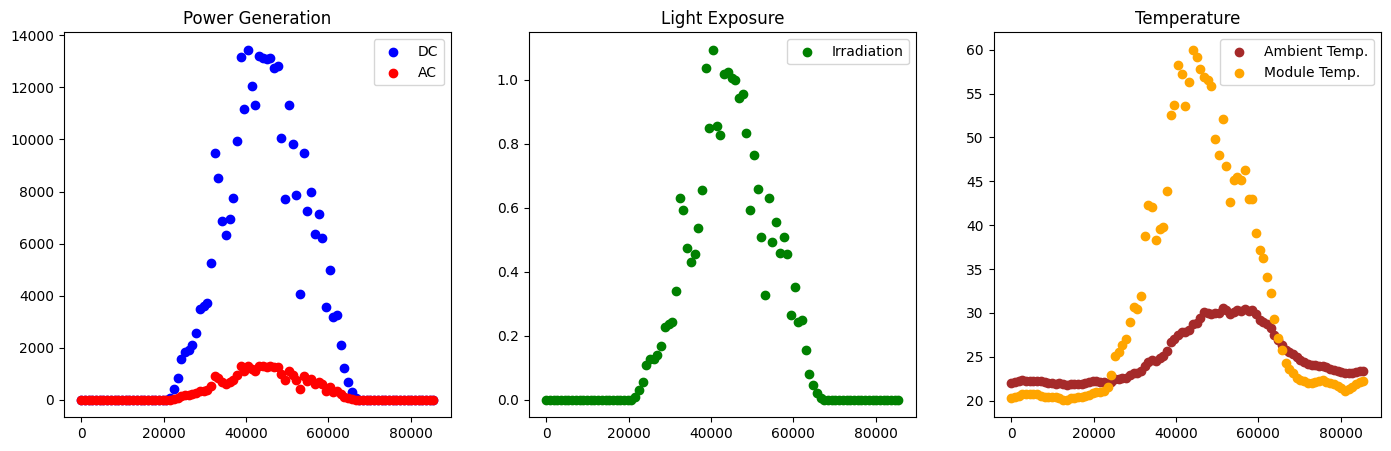

In [906]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
axes[0].scatter(x=times, y=individual_source.get('DC_POWER'), label='DC', color='blue')
axes[0].scatter(x=times, y=individual_source.get('AC_POWER'), label='AC', color='RED')
axes[0].legend()
axes[0].set_title('Power Generation')
axes[1].scatter(x=times, y=individual_source.get('IRRADIATION'), label='Irradiation', color='green')
axes[1].legend()
axes[1].set_title('Light Exposure')
axes[2].scatter(x=times, y=individual_source.get('AMBIENT_TEMPERATURE'), label='Ambient Temp.', color='Brown')
axes[2].scatter(x=times, y=individual_source.get('MODULE_TEMPERATURE'), label='Module Temp.', color='Orange')
axes[2].legend()
axes[2].set_title('Temperature')
plt.show()

After plotting the numbers for one day, we can see that power generation is very high correlated with our irradiation (our light exposure). This light expore is similarly correlated with the rise and fall of temperature as well. Using basic reasoning, its likely not directly related to the exact temperature, but rather the fact that temperature rises due to increased sun exposure.

In [907]:
irradiation = plant1_xr['IRRADIATION']
dc_power = plant1_xr['DC_POWER']

# Step 2: Align the two variables along their shared dimensions (DATE_TIME)
aligned_irradiation, aligned_dc_power = xr.align(irradiation, dc_power, join='inner')

# Step 3: Compute the covariance (using xarray's covariance function)
correlation = xr.corr(aligned_irradiation, aligned_dc_power, dim='SECONDS')

print(correlation.values.mean())

0.9902484879302703


We can see that for every SOURCE_KEY (for every solar farm) our data has an extremely high correlation coefficient. This means that irradiation is a __very__ strong predictor for dc power generation

### Modeling

#### Goal:
 - In the real world, we likely won't have access to irradiation but __not__ have our DC_POWER. This means we are going to need to look into the past to predict how the future will perform
 - To maintain this reality, we will likely take one day prior, and attempt to predict the next day in our dataset
 - Since we have two equally sized datasets, to keep things simple we will use one as our training set, and the other as our testing set.
 - These two plants cover the same date range, so we do not have to worry about different seasons impacting the performance.
 - As far as which data to include in X, seeing as the daily report on both weather and power generation would likely be available immediately, we can include everything from the prior day.
 - For the Y, since we are concerned with power generation, lets initially try and predict for both DC and AC power.

#### Problems:
 - Our dataset only contains values from may - june. This means we are __not__ dealing with a major shift in seasons
 - Due to this, our model will likely __not__ generalize well onto all real-world data.
 - This being said, we will likely be able to predict weather within this time range reasonably well on real world data.

### Steps:
 - In order to build this model, we will first need some tools so that we can extract one day from the dataset, and then the next day. So that we can train out model.
 - Our X will be the day prior, and our Y will be the day we are trying to predict.

In [908]:
def get_available_days(xr):
    available_days = xr.get('DAY').dt.date
    available_days = available_days[:-1].to_numpy() #cant include last day, since there isnt a day after it to predict on.
    return available_days

def get_X_Y(plant_xr, date=None, plant=None):
    if not date:
        available_days = get_available_days(plant_xr)
        date = np.random.choice(available_days, replace=True)
    if not plant:
        plant = np.random.choice(plant_xr['SOURCE_KEY'].values)

    X_day = date
    Y_day = date + pd.Timedelta(days=1)
    one_plant = plant_xr.sel(SOURCE_KEY=plant)

    X = one_plant.where(one_plant['DAY'].dt.date == X_day, drop=True).squeeze()
    Y = one_plant.where(one_plant['DAY'].dt.date == Y_day, drop=True)
    Y = Y[['AC_POWER']]

    x = X.to_array().values.T
    y = np.array([Y[var].values.flatten() for var in Y.data_vars]).flatten()
    return x, y


"""
    X = one_plant.where(one_plant['DAY'].dt.date == X_day, drop=True).squeeze()
    Y = one_plant.where(one_plant['DAY'].dt.date == Y_day, drop=True).squeeze()
    Y = Y[['DC_POWER', 'AC_POWER']]
    return X.to_array().values.T, Y.to_array().values.T

x, y = get_X_Y(plant1_xr)
sequence_length = x.shape[0]
input_shape, output_shape = x.shape[1], y.shape[1]
input_shape, output_shape, sequence_length
"""

x, y = get_X_Y(plant1_xr)
sequence_length = x.shape[0]
input_shape, output_shape = x.shape[1], y.shape[0]
input_shape, output_shape, sequence_length

(7, 96, 96)

Now that we can get the values for one day, and we have our model dimensions, lets get to building the full train/test split.

In [914]:
def batch_X_Y(plant1_xr, plant2_xr, test=0.2, validation=0.1):
    available_days = get_available_days(plant1_xr)
    days_indexes = np.random.permutation(np.arange(available_days.shape[0]))

    num_test = int(np.ceil(available_days.shape[0] * test))
    num_validation = int(np.ceil(available_days.shape[0] * validation))
    test_days, validation_days, train_days = available_days[days_indexes[:num_test]], available_days[days_indexes[num_test:num_test+num_validation]], available_days[days_indexes[num_test+num_validation:]]

    source_keys1 = plant1_xr['SOURCE_KEY'].values
    source_keys2 = plant2_xr['SOURCE_KEY'].values

    def get_all_days(dataset, day_list, key_list):
        X = []
        Y = []
        for day in day_list:
            for key in key_list:
                x, y = get_X_Y(dataset, day, key)
                X.append(x)
                Y.append(y)
        return X, Y
    
    train_x_1, train_y_1 = get_all_days(plant1_xr, train_days, source_keys1)
    train_x_2, train_y_2 = get_all_days(plant2_xr, train_days, source_keys2)
    train_x = np.stack(train_x_1 + train_x_2, axis=0)
    train_y = np.stack(train_y_1 + train_y_2, axis=0)


    test_x_1, test_y_1 = get_all_days(plant1_xr, test_days, source_keys1)
    test_x_2, test_y_2 = get_all_days(plant2_xr, test_days, source_keys2)
    test_x = np.stack(test_x_1 + test_x_2, axis=0)
    test_y = np.stack(test_y_1 + test_y_2, axis=0)

    validation_x_1, validation_y_1 = get_all_days(plant1_xr, validation_days, source_keys1)
    validation_x_2, validation_y_2 = get_all_days(plant2_xr, validation_days, source_keys2)
    validation_x = np.stack(validation_x_1 + validation_x_2, axis=0)
    validation_y = np.stack(validation_y_1 + validation_y_2, axis=0)

    return train_x, train_y, test_x, test_y, validation_x, validation_y

def batch_X_Y_oneds(plant_xr, test=0.2, validation=0.1):
    available_days = get_available_days(plant_xr)
    days_indexes = np.random.permutation(np.arange(available_days.shape[0]))

    num_test = int(np.ceil(available_days.shape[0] * test))
    num_validation = int(np.ceil(available_days.shape[0] * validation))
    test_days, validation_days, train_days = available_days[days_indexes[:num_test]], available_days[days_indexes[num_test:num_test+num_validation]], available_days[days_indexes[num_test+num_validation:]]

    source_keys = plant_xr['SOURCE_KEY'].values

    def get_all_days(dataset, day_list, key_list):
        X = []
        Y = []
        for day in day_list:
            for key in key_list:
                x, y = get_X_Y(dataset, day, key)
                X.append(x)
                Y.append(y)
        return X, Y
    
    train_x, train_y = get_all_days(plant_xr, train_days, source_keys)
    test_x, test_y = get_all_days(plant_xr, test_days, source_keys)
    validation_x, validation_y = get_all_days(plant_xr, validation_days, source_keys)

    train_x, train_y = np.stack(train_x, axis=0), np.stack(train_y, axis=0)
    test_x, test_y = np.stack(test_x, axis=0), np.stack(test_y, axis=0)
    validation_x, validation_y = np.stack(validation_x, axis=0), np.stack(validation_y, axis=0)

    return train_x, train_y, test_x, test_y, validation_x, validation_y

def permute_batch(X, Y):
    """
    Randomly permutes a batch of obserations. If this was not done, the model would
    simply predict the next day in the training batch, as that is the target.
    By changing the permutation each epoch of training, this ensures the model is learning
    the relationship between xi and yi, instead of learning the relationship between
    xi and xi+1
    """
    permutation = np.random.permutation(X.shape[0])
    return X[permutation], Y[permutation]

#X_train, Y_train, X_test, Y_test = batch_X_Y(plant1_xr, plant2_xr)
X_train, Y_train, X_test, Y_test, X_validation, Y_validation = batch_X_Y_oneds(plant1_xr)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_validation.shape, Y_validation.shape

((484, 96, 7), (484, 96), (154, 96, 7), (154, 96), (88, 96, 7), (88, 96))

Looks good! We have all our data. Let's work on building a model now. After doing some online research, it seems an XGBoost model works best. Let's try that.

In [915]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

class TCNModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_channels, kernel_size=3, dropout=0.2):
        super(TCNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, num_channels, kernel_size, padding=kernel_size-1, dilation=1)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size, padding=kernel_size-1, dilation=1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_channels, output_dim)

    def forward(self, x):
        # input shape: (batch_size, seq_length, input_dim)
        x = x.transpose(1, 2) 
        x = torch.relu(self.conv1(x))
        x = self.dropout(x)
        x = torch.relu(self.conv2(x))
        x = x.mean(dim=-1)  # average pooling
        x = self.fc(x)
        return x


In [927]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)
X_validation_tensor = torch.tensor(X_validation, dtype=torch.float32)
Y_validation_tensor = torch.tensor(Y_validation, dtype=torch.float32)

# Create DataLoader for batch training
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [925]:
# Initialize the model, loss function, and optimizer
input_dim = input_shape
output_dim = output_shape



def train_model(num_channels, kernel_size, dropout=0.2, epochs=15):
    model = TCNModel(input_dim=input_dim, output_dim=output_dim, num_channels=num_channels, kernel_size=kernel_size, dropout=dropout)
    loss_fn = nn.MSELoss()  # Mean squared error for regression
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
    
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients
            Y_pred = model(X_batch)  # Forward pass
            loss = loss_fn(Y_pred, Y_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            epoch_loss += loss.item()
    
    # Evaluate the model on test data
    model.eval()
    with torch.no_grad():
        Y_test_pred = model(X_test_tensor)
        test_loss = loss_fn(Y_test_pred, Y_test_tensor).item()
    return model, test_loss



hyper_channels = [64, 128, 256, 512]
hyper_kernel = [2, 3, 4, 5]
best_loss = np.inf
best_channels, best_kernels, best_model = None, None, None

for channel in hyper_channels:
    for kernel in hyper_kernel:
        model, loss = train_model(channel, kernel)
        if loss < best_loss:
            best_loss = loss
            best_channels, best_kernels, best_model = channel, kernel, model

        print(f'channels: {channel}, kernel size: {kernel}, test loss: {loss}')

print(f"Best Model Parameters: \n \t num_channels: {best_channels} \n \t kernel_size: {best_kernels} \n \t Loss on Test Data: {best_loss}")

channels: 64, kernel size: 2, test loss: 1178631.875
channels: 64, kernel size: 3, test loss: 664533.9375
channels: 64, kernel size: 4, test loss: 317515.75
channels: 64, kernel size: 5, test loss: 275297.53125
channels: 128, kernel size: 2, test loss: 1056997.375
channels: 128, kernel size: 3, test loss: 291754.59375
channels: 128, kernel size: 4, test loss: 269373.75
channels: 128, kernel size: 5, test loss: 253404.796875
channels: 256, kernel size: 2, test loss: 257518.015625
channels: 256, kernel size: 3, test loss: 98500.265625
channels: 256, kernel size: 4, test loss: 225967.65625
channels: 256, kernel size: 5, test loss: 257306.875
channels: 512, kernel size: 2, test loss: 70709.71875
channels: 512, kernel size: 3, test loss: 215470.78125
channels: 512, kernel size: 4, test loss: 31694.474609375
channels: 512, kernel size: 5, test loss: 254087.671875
Best Model Parameters: 
 	 num_channels: 512 
 	 kernel_size: 4 
 	 Loss on Test Data: 31694.474609375


In [929]:
model = best_model
model.eval()
loss_fn = nn.MSELoss()
with torch.no_grad():
    Y_validation_pred = model(X_validation_tensor)
    validation_loss = loss_fn(Y_validation_pred, Y_validation_tensor).item()
print(f"Loss on validation Data: {validation_loss}")

Loss on validation Data: 38251.84375


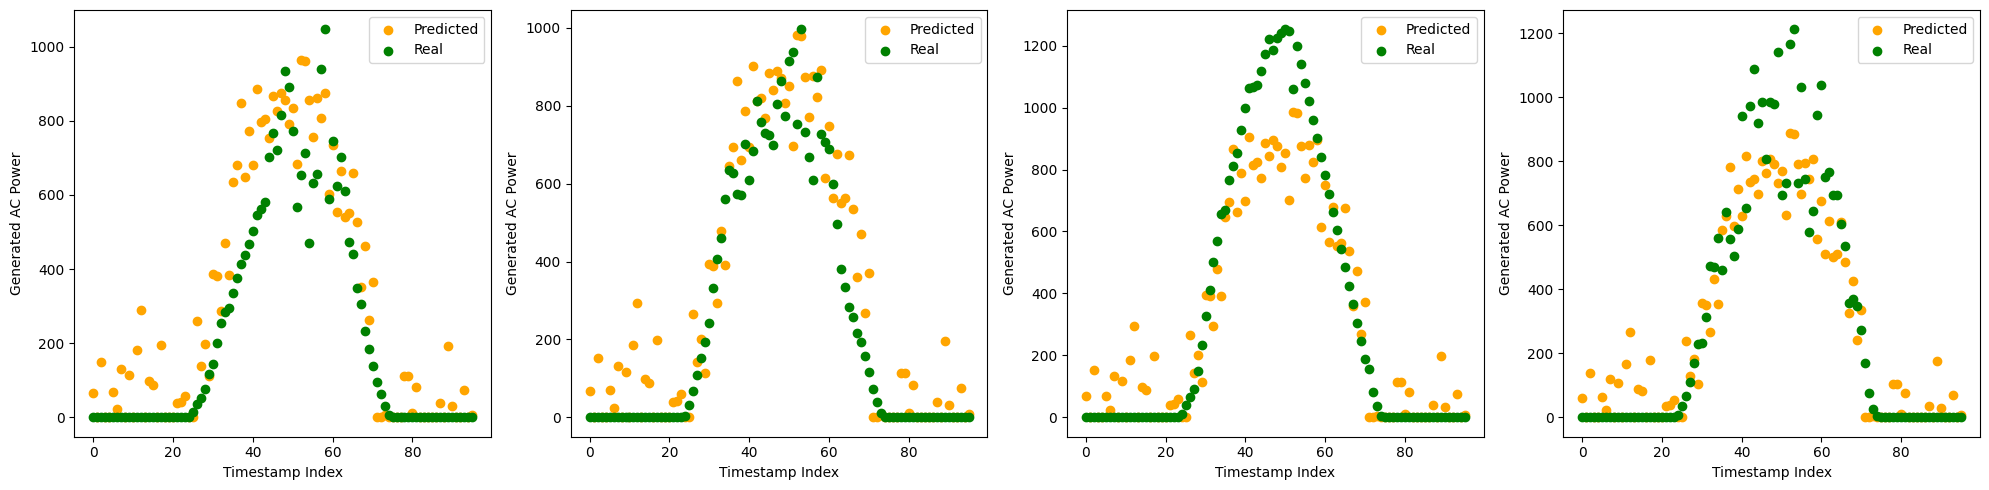

In [946]:
# Assuming `X_new` is the new input data (shape: [num_samples, input_dim])

def add_plot(ax):
    X_new, Y_new = get_X_Y(plant1_xr)
    X_new_tensor = torch.tensor(X_new, dtype=torch.float32).unsqueeze(0)

    # Set the model to evaluation mode
    model.eval()

    # Predict Y_new
    with torch.no_grad():
        Y_new_pred = model(X_new_tensor).numpy()  # Convert to NumPy array
        Y_new_pred[Y_new_pred < 0] = 0
        
    ax.scatter(x=np.arange(0, Y_new_pred.shape[1]), y=Y_new_pred[0], color='orange', label='Predicted')
    ax.scatter(x=np.arange(0, Y_new_pred.shape[1]), y=Y_new, color='green', label='Real')
    ax.set_xlabel('Timestamp Index')
    ax.set_ylabel('Generated AC Power')
    ax.legend()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
[add_plot(ax) for ax in axes]
plt.tight_layout()
plt.show()